In [332]:
import torch 
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, re

%matplotlib inline

In [333]:
import praw

user_agent = "Scraper 1.0 by /u/arnavg13"
reddit = praw.Reddit(
    client_id = "i69a55gneYS1cazqZCBE1g", 
    client_secret = "kxUTufTD_13UMTooaGidM3uNDAg7_A",
    user_agent = user_agent
)

In [336]:
subreddit = reddit.subreddit("progresspics")
posts = subreddit.hot(limit = 500) 
file_names, raw_labels, metadata = [], [], []
for i, post in enumerate(posts):
    url = post.url
    file_name = url.split("/")
    if not len(file_name):
        file_name = re.findall("/(.*?)", url)
    file_name = file_name[-1]
    if "." not in file_name:
        continue
    r = requests.get(url)
    with open("images/_" + str(i) + ".jpg", "wb") as f:
        f.write(r.content)
    file_names.append(file_name)
    raw_labels.append(post.title)
    metadata.append(post.link_flair_text)

Our first task is to get the exact heights from each person's annotations on the subreddit. We do this in an automated fashion for every example using the get_height function below. 

In [337]:
def get_height(i, raw_labels, metadata):
    """
    Using both the annotations and the flair text, we gather enough information to access 
    the exact height of each individual in inches. If there is no valid information in either
    datum, we will return None to indicate that this datapoint is not useful and needs to be removed. 
    """
    label = raw_labels[i]
    flair_text = metadata[i]
    if flair_text and flair_text != 'n/a':
        curr = flair_text.split()[1]
        H_feet = curr.split("'")[0]
        H_inch = curr.split("'")[1].split("”")[0]
        height = int(H_feet) * 12 + int(H_inch)
    else:
        curr = label.split()[0].split("/")[2]
        # Figure out the number of feet
        if '’' in curr:
            cand_feet = curr.split("’")[0]
            if '"' in cand_feet or '’' in cand_feet or '”' in cand_feet or "“" in cand_feet:
                return None
            if 'ft' in cand_feet:
                return None
            # Consider the case where we get cm instead -- we don't want this. 
            if int(cand_feet) > 7:
                return None
            feet = cand_feet
            if len(curr.split("’")) == 1:
                cand_inches = 0
            else:
                if curr.split("’")[1] == '':
                    cand_inches = 0
                elif "”" not in curr.split("’")[1]:
                    cand_inches = curr.split("’")[1][0]
                else:
                    cand_inches = curr.split("’")[1].split("”")[0]
            inches = cand_inches
        else:
            cand_feet = curr.split("'")[0]
            if '"' in cand_feet or '’' in cand_feet or '”' in cand_feet or "“" in cand_feet:
                return None
            if 'ft' in cand_feet:
                return None
            # Consider the case where we get cm instead -- we don't want this. 
            if int(cand_feet) > 7:
                return None
            feet = cand_feet
            if len(curr.split("'")) == 1:
                cand_inches = 0
            else:
                if curr.split("'")[1] == '':
                    cand_inches = 0
                elif "”" not in curr.split("'")[1]:
                    cand_inches = curr.split("'")[1][0]
                else:
                    cand_inches = curr.split("'")[1].split("”")[0]
            inches = cand_inches
        height = int(feet) * 12 + int(inches)
    return height

Next, we need to get the weights. Here, there is a bit more difficulty. These weights are the most important labels because height is ignorable, but weight is the most important feature we want to use to determine BMI and even simply predict the weight. As such, every weight is in the format of "[w1 > w2 = w1 - w2]" with units and other data in between. However, these labels only have two reallly important parts -- 1) the first weight mentioned and 2) the second weight mentioned. After we get these, we will store a tuple-per-person, now holding all their weights. For now, we will only capture those who have at most two weights. 

In [354]:
def get_weights(i, raw_labels):
    label = raw_labels[i]
    regex = r"\[([^)]+)\]"
    if '[' not in label and ']' not in label:
        return None
    if 'KG' in label or "pounds" in label or "lost" in label:
        return None
    bracket_content = re.findall(regex, label)[0]
    if '[' in bracket_content or ']' in bracket_content or '>' not in bracket_content:
        return None
    if bracket_content.count(">") != 1 or '?' in bracket_content or 'kg' in bracket_content:
        return None
    if bracket_content.count(">") + bracket_content.count("<") >= 2:
        return None
    if '-' in bracket_content or '–' in bracket_content:
        return None
    else:
        bracket_content = bracket_content.replace("lbs", "")
        bracket_content = bracket_content.replace(" ", "").replace("llb", "")
        bracket_content = bracket_content.replace("lb", "").replace("Ibs", "")
        bracket_content = bracket_content.replace("lost", "").replace("+", "")
        bracket_content = bracket_content.replace("#", "").replace("bs", "")
        head, sep, tail = bracket_content.partition("=")
        first, second = head.split(">")
        if float(first) < 100 or len(first) > 3:
            return None
        else:
            first = float(first)
        if float(second) < 100 or len(second) > 3:
            return None
        else:
            second = float(second)
        return (first, second)

The following function is needed for filtration -- if we have a value that is None for either height or weight, we need to get rid of it from our dataset. 

In [360]:
def remove_value(i):
    raw_labels.pop(i)
    metadata.pop(i)
    file_names.pop(i)

Finally, let's build up three datastores -- one of the "heights", one of the "first_weight", and one of the "second_weight." With all three of these, the ith entry corresponds to one individual. 

In [361]:
def height_and_weight_labels():
    heights, weights_1, weights_2 = [], [], []
    for i in range(len(metadata)):
        height, weights = get_height(i, raw_labels, metadata), get_weights(i, raw_labels)
        if height and weights:
            heights.append(height)
            weights_1.append(weights[0])
            weights_2.append(weights[1])
    return heights, weights_1, weights_2

In [362]:
heights, weights_1, weights_2 = height_and_weight_labels()

In [363]:
heights[:10]

[64, 62, 70, 67, 62, 59, 66, 69, 74, 67]

In [364]:
weights_1[:10]

[227.0, 145.0, 350.0, 287.0, 210.0, 119.0, 201.0, 240.0, 227.0, 169.0]

In [365]:
weights_2[:10]

[171.0, 130.0, 185.0, 203.0, 174.0, 109.0, 130.0, 185.0, 208.0, 159.0]

The more difficult component now is to actually gather the corresponding images. As we know, we already have the weights stored as tuples, but these are naturally more than one. As such, we need to match the tuple element to the corresponding image. Sadly, each image we have collected is just that -- only an image. However, semantically, it contains multiple sub-images. The task we need to figure out is cropping out these subimages and using them individually, per person, and then storing them with their corresponding labels. 

In [366]:
from PIL import Image
import glob

images = []
for filename in glob.glob('images/*.jpg'): #assuming gif
    im = Image.open(filename)
    images.append(np.array(im))

In [392]:
import cv2
from imutils.object_detection import non_max_suppression
import imutils
import PIL

def create_bounding_box(i):
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    image = cv2.imread("images/_" + str(i) + ".jpg")
    # image = imutils.resize(image, width=min(400, image.shape[1]))
    orig = image.copy()

    (rects, weights) = hog.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.05)
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
        
    plt.imshow(orig)

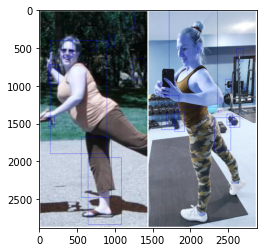

In [394]:
create_bounding_box(40)